Note: My explanations on the regression dataset are a bit more detailed as I started with this one and do not want to repeat too much. Please start with the regression when correcting. Obrigado.

In [160]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim


In [161]:
# Classification dataset - diabetes
data = datasets.fetch_openml(name="diabetes",version=1, as_frame=True) 

X = data.data.values
y = data.target.values 
y = (y == 'tested_positive').astype(float)  # convert to binary 0/1

In [162]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [163]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)

So far, the diabetes dataset has been loaded, randomly divided into 80% training data and 20% percent test data and scaled. Since the labels were stored as strings they need to be converted to binary (float) values.

In the following, the number of the clusters and the smoothness of each cluster m can be tuned. I decided to use a grid search to find a suitable combination of parameters, which can be found at the end of this notebook. 

Note: I ran the grid search multiple times and somehow the results kept changing a tiny bit. However, I decided to go with a simple model that has only two clusters, which makes it easy to interpret and reduces computational cost but still appeared in the top 3 all the time.


In [164]:
 # Number of clusters 
n_clusters = 2
m=1.75

# Concatenate target for clustering
Xexp=np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

In [165]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

The following plot shows two out of eight features and their clustering. Clearly age must have a big affect on the clustering, as the clusters can be easily divided into "old" and "young".

Fuzzy partition coefficient (FPC): 0.5562810794042788


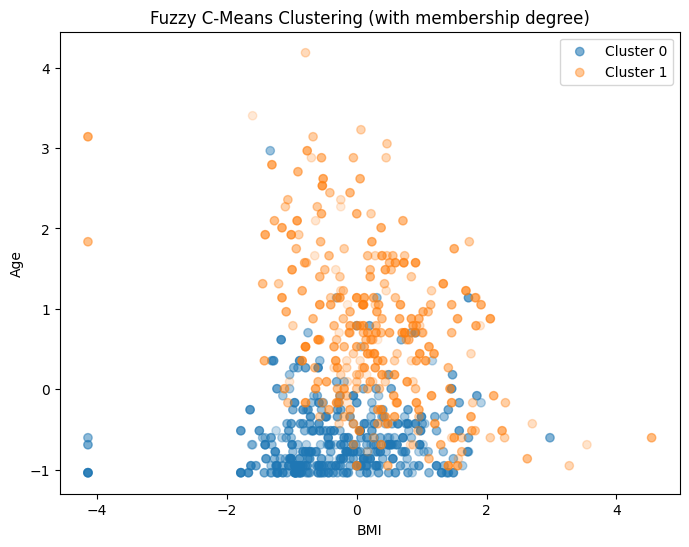

In [166]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

# Plot two features with fuzzy membership
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 5],             # BMI
        Xexp[cluster_labels == j, 7],             # Age
        alpha=u[j, :],          # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("BMI")
plt.ylabel("Age")
plt.legend()
plt.show()

The following plot proves my previous point, as the feature "age" yields the clearest separation of the curves. In contrast, the feature "Skin thickness" barely influences the clustering, as the membership functions are almost overlapping.

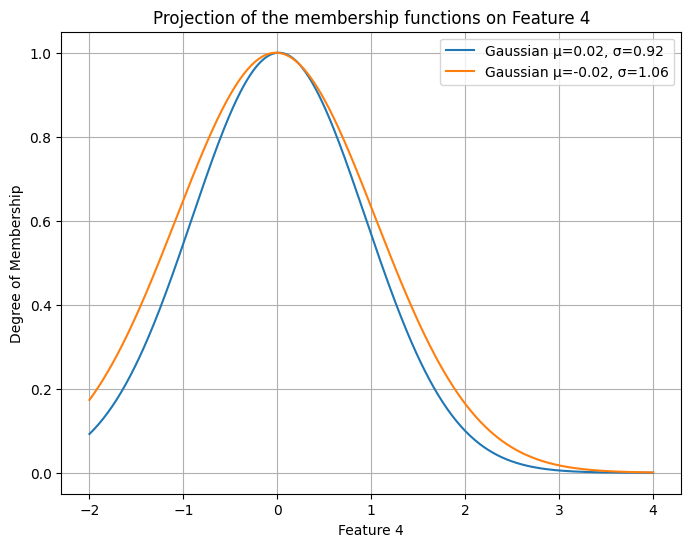

In [167]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-2, 4, 500)
plt.figure(figsize=(8,6))

y_aux=[]
for j in range(n_clusters):

# Select feature to be shown
    ft=4  # e.g. Feature 8 = Age; Feature 4 = Skin Thickness
    fti=ft-1  # index correction

# Compute curves
    y_aux.append(gaussian(lin, centers[j,fti], sigmas[j,fti]))

# Plot
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,fti],2)}, σ={np.round(sigmas[j,fti],2)}")

plt.title(f"Projection of the membership functions on Feature {ft}")
plt.xlabel(f"Feature {ft}")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

In [168]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs



In [169]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)


In [170]:
# Build model
model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])
# model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers, sigmas=sigmas) # For comparison without target


Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)

In [171]:
# Training with LS:
train_ls(model, Xtr, ytr.reshape(-1,1))

The accuracy of a classification is simply given by the percentage of correctly classified data. Since the target labels are crisp, a threshold needs to be defined (typically 0.5).

In [172]:
y_pred, _, _=model(Xte)
print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification

ACC:0.7857142857142857


The following grid search method was implemented by MS Copilot. Several parameters lead to very similar accuracy around 79%. Thus, a simpler method with only two clusters is preferred.

In [173]:
# ---------------------------
# Grid search for highest classification accuracy (no MSE)
# Treat the continuous target as binary by thresholding at the training-set median.
# This cell searches n_clusters in [2..8] and m in [1.1,1.3,1.5,1.75,2.0,2.25,2.5]
# Primary metric: accuracy (higher is better). Pure classification, MSE removed.
# ---------------------------

n_clusters_list = [2, 3, 4, 5, 6, 7, 8]
m_list = [1.1, 1.3, 1.5, 1.75, 2.0, 2.25, 2.5]

# Prepare numpy arrays
Xtr_np = Xtr.detach().numpy() if isinstance(Xtr, torch.Tensor) else np.array(Xtr)
ytr_np = ytr.detach().numpy().reshape(-1, 1) if isinstance(ytr, torch.Tensor) else np.array(ytr).reshape(-1,1)
Xte_np = Xte.detach().numpy() if isinstance(Xte, torch.Tensor) else np.array(Xte)
yte_np = yte.detach().numpy().reshape(-1, 1) if isinstance(yte, torch.Tensor) else np.array(yte).reshape(-1,1)

# Binarize targets using training median (pure classification)
thr = np.median(ytr_np)
ytr_bin = (ytr_np > thr).astype(float)
yte_bin = (yte_np > thr).astype(float)

results = []
import time
start_time = time.time()

for n_c in n_clusters_list:
    for m_val in m_list:
        try:
            # Use binary target in concatenated space for clustering
            Xexp = np.concatenate([Xtr_np, ytr_bin], axis=1)
            Xexp_T = Xexp.T

            centers_tmp, u_tmp, u0, d, jm, p, fpc_tmp = fuzz.cluster.cmeans(
                Xexp_T, n_c, m=m_val, error=0.005, maxiter=1000, init=None
            )

            # Compute sigmas for each cluster (weighted variance)
            sigmas_tmp = []
            for j in range(n_c):
                u_j = u_tmp[j, :] ** m_val
                var_j = np.average((Xexp - centers_tmp[j])**2, axis=0, weights=u_j)
                sigma_j = np.sqrt(var_j)
                sigmas_tmp.append(sigma_j)
            sigmas_tmp = np.array(sigmas_tmp)

            # Build TSK model using input dims only (exclude appended target column)
            model_tmp = TSK(n_inputs=Xtr.shape[1], n_rules=n_c, centers=centers_tmp[:,:-1], sigmas=sigmas_tmp[:,:-1])

            # Train consequents with LS on binary labels
            train_ls(model_tmp, torch.tensor(Xtr_np, dtype=torch.float32), torch.tensor(ytr_bin, dtype=torch.float32))

            # Evaluate on test set
            y_pred_tmp, _, _ = model_tmp(torch.tensor(Xte_np, dtype=torch.float32))
            y_pred_np = y_pred_tmp.detach().numpy().reshape(-1,1)

            # Binarize predictions at 0.5
            y_pred_bin = (y_pred_np >= 0.5).astype(float)

            acc = accuracy_score(yte_bin, y_pred_bin)

            results.append({'n_clusters': n_c, 'm': m_val, 'accuracy': float(acc), 'fpc': float(fpc_tmp)})
            print(f'n_clusters={n_c}, m={m_val}, acc={acc:.4f}, fpc={fpc_tmp:.6f}')
        except Exception as e:
            print(f'Skipped n_clusters={n_c}, m={m_val} due to error: {e}')

# Summarize results
import pandas as pd
if len(results) == 0:
    print('Grid search produced no results')
else:
    df = pd.DataFrame(results)
    # Sort by accuracy descending (pure classification)
    df_sorted = df.sort_values('accuracy', ascending=False)

    best = df_sorted.iloc[0]
    print('\nBest grid-search result (highest accuracy):')
    print(f"n_clusters: {int(best['n_clusters'])}, m: {best['m']}, accuracy: {best['accuracy']:.4f}, fpc: {best.get('fpc', np.nan):.6f}")

    print('\nTop 5 results:')
    print(df_sorted.head(5).to_string(index=False))

end_time = time.time()
print(f'Grid search finished in {end_time - start_time:.1f}s')


n_clusters=2, m=1.1, acc=0.7662, fpc=0.925032
n_clusters=2, m=1.3, acc=0.7662, fpc=0.776372
n_clusters=2, m=1.5, acc=0.7792, fpc=0.654249
n_clusters=2, m=1.75, acc=0.7857, fpc=0.556325
n_clusters=2, m=2.0, acc=0.7468, fpc=0.504938
n_clusters=2, m=2.25, acc=0.7468, fpc=0.500005
n_clusters=2, m=2.5, acc=0.7468, fpc=0.500001
n_clusters=3, m=1.1, acc=0.7662, fpc=0.918832
n_clusters=3, m=1.3, acc=0.7468, fpc=0.719294
n_clusters=3, m=1.5, acc=0.7597, fpc=0.547395
n_clusters=3, m=1.75, acc=0.7597, fpc=0.403810
n_clusters=3, m=2.0, acc=0.7468, fpc=0.337879
n_clusters=3, m=2.25, acc=0.7468, fpc=0.333336
n_clusters=3, m=2.5, acc=0.7532, fpc=0.333334
n_clusters=4, m=1.1, acc=0.7338, fpc=0.909183
n_clusters=4, m=1.3, acc=0.7727, fpc=0.656831
n_clusters=4, m=1.5, acc=0.7597, fpc=0.465981
n_clusters=4, m=1.75, acc=0.7727, fpc=0.311481
n_clusters=4, m=2.0, acc=0.7532, fpc=0.253857
n_clusters=4, m=2.25, acc=0.7468, fpc=0.250005
n_clusters=4, m=2.5, acc=0.6688, fpc=0.250001
n_clusters=5, m=1.1, acc=0.7